In [2]:
import matplotlib.pyplot as plt
from sklearn import tree
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from statistics import mode
import plotly.express as px
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, recall_score,
                             roc_auc_score)
from sklearn.model_selection import (StratifiedKFold, cross_val_score,
                                     learning_curve, train_test_split, KFold)
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [5]:
df = pd.read_csv("starclassification.csv")

In [6]:
df

wavelength_alpha  wavelength_beta  wavelength_gamma  intensity_delta  \
0            24.980326        51.445268         52.620208        54.064555   
1            46.313938        57.679403         58.389993        43.238722   
2            32.699599        62.227628         58.032217        23.819467   
3             8.144348        50.780760         45.763862        30.968590   
4            45.845400        84.913413         53.670683        55.602772   
...                ...              ...               ...              ...   
1993         63.523806        60.650830         53.594411        57.734056   
1994         58.652411        63.723648         61.841085        59.285407   
1995               NaN        73.266760               NaN        62.812923   
1996         77.234802        62.634575         50.345275        82.863786   
1997         69.909820        75.944679         61.249195        71.295587   

      isStar  
0      False  
1      False  
2      False  
3      False  
4       True  
...      ...  
1993   False  
1994   False  
1995   False  
1996   False  
1997   False  

[1998 rows x 5 columns]

In [7]:
df.dtypes

wavelength_alpha    float64
wavelength_beta     float64
wavelength_gamma    float64
intensity_delta     float64
isStar                 bool
dtype: object

# Let's see if there's any null data, and if so, how many. We will use this information when we are cleaning our data.

In [8]:
df.isna().sum()

wavelength_alpha    102
wavelength_beta     100
wavelength_gamma    105
intensity_delta     102
isStar                0
dtype: int64

In [9]:
df["isStar"].value_counts()

False    1331
True      667
Name: isStar, dtype: int64

# ~ Plots
Data visualization is a crucial part of building a robust machine learning model. By visualizing our model, we can note down a lot of key points of the data set that we would not be able to realize from a 2000 row data. It helps us realize correlations, outliers, missing data, etc... 

In [10]:
not_star_max = df["isStar"].value_counts()[0]
star_max = df["isStar"].value_counts()[1]

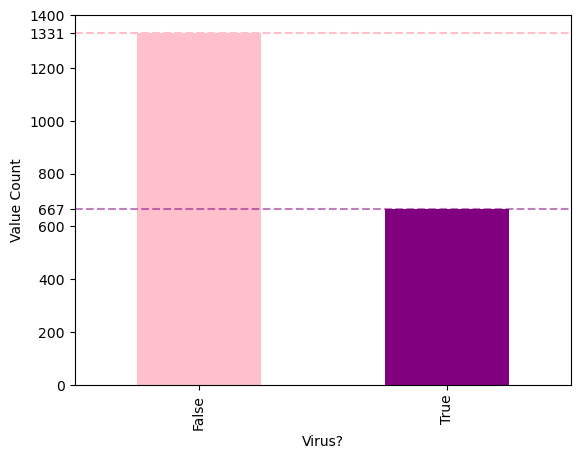

In [11]:
ax = df["isStar"].value_counts().plot.bar(xlabel='star?', ylabel='Value Count', color = ["pink", "purple"])
plt.axhline(y=not_star_max, color='pink', linestyle='--')
plt.axhline(y=star_max, color='purple', linestyle='--', alpha=0.5)

extraticks = [not_star_max, star_max]
ax.set_yticks(list(ax.get_yticks()) + extraticks)


plt.show()

In [12]:
corr = df.corr()
corr.style.background_gradient(cmap='RdPu').format(precision=2)

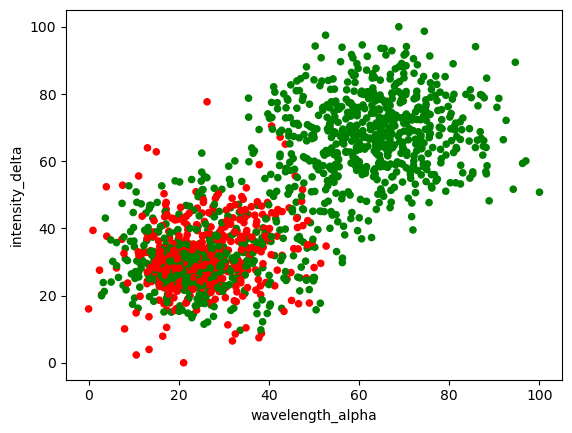

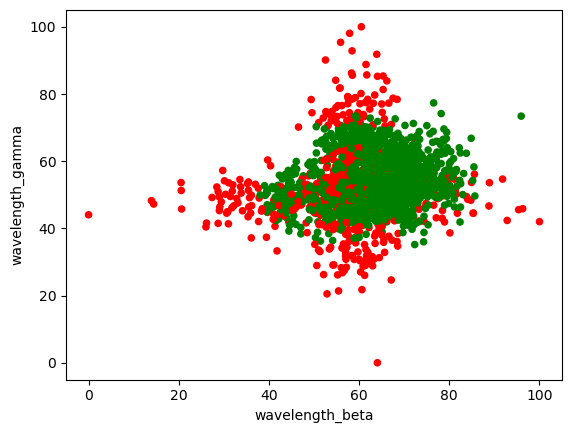

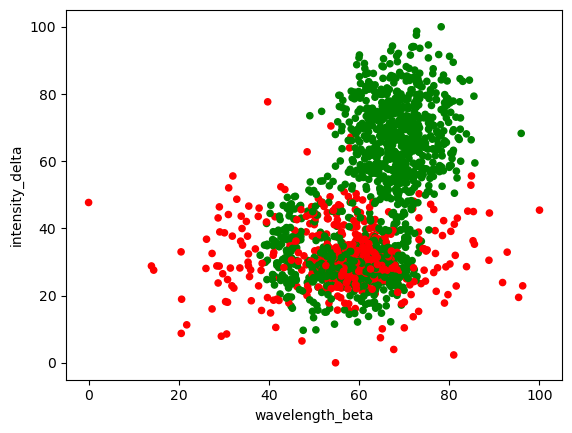

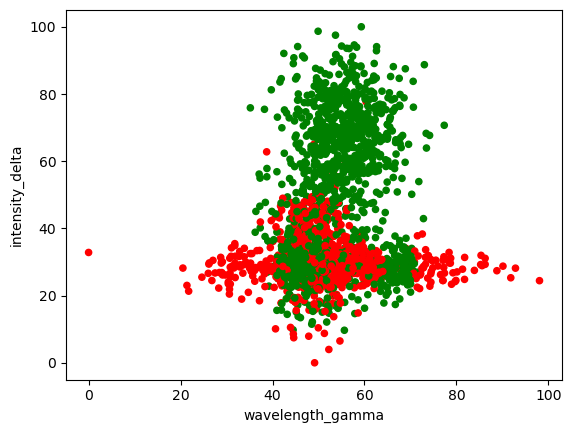

In [13]:
colors = np.where(df["isStar"]==True,'red','green')
for x, y in combinations(df.drop(columns="isStar").columns, r=2):
    ax = df.plot.scatter(x=x, y=y, c=colors)

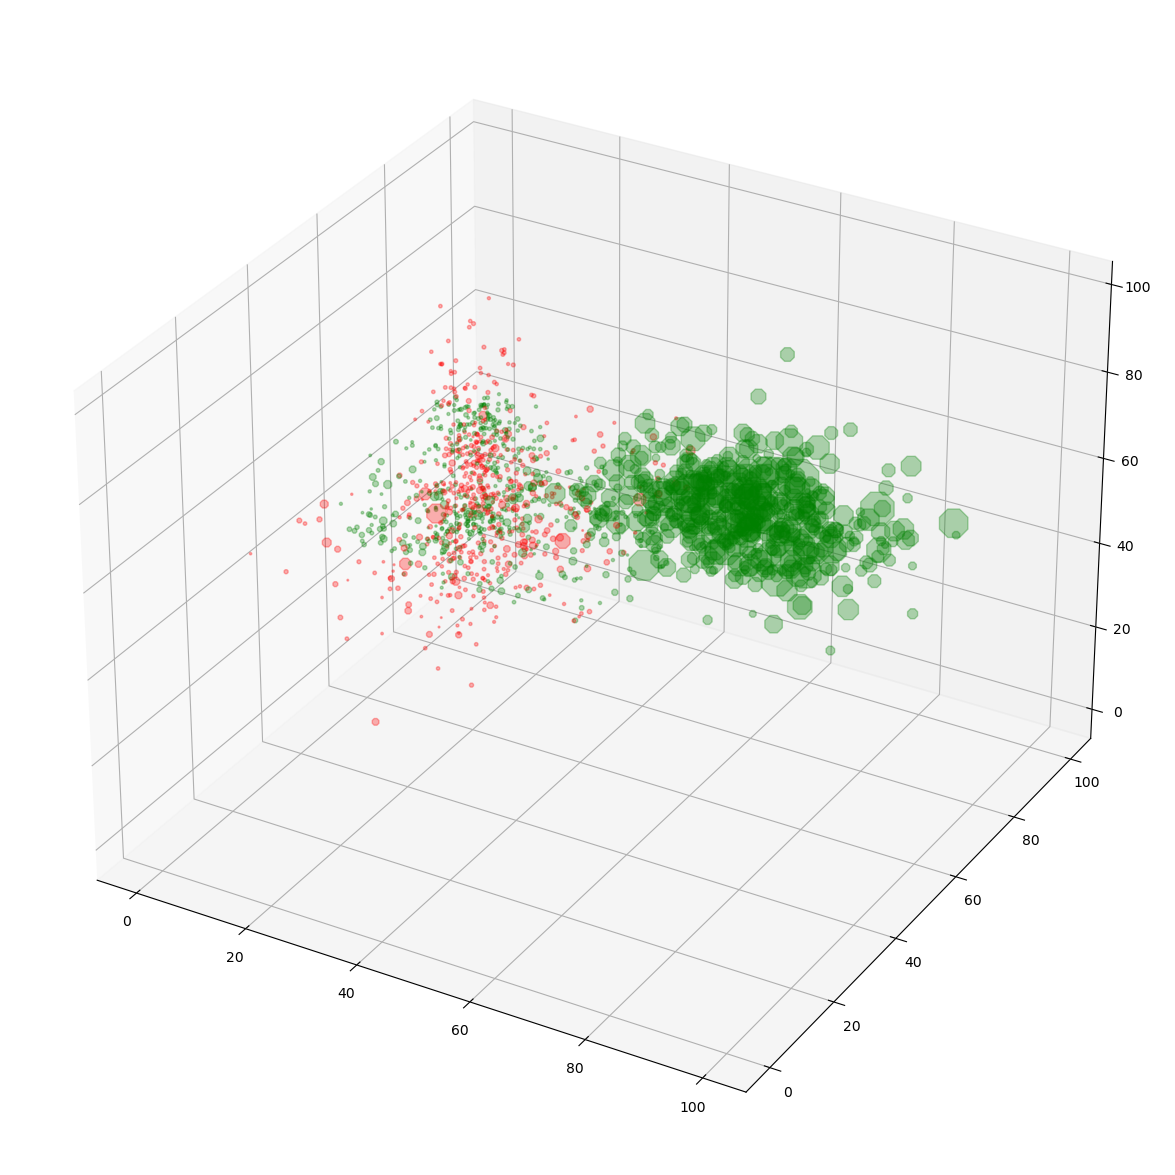

In [70]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')


colors = np.where(df["isStar"]==True,'red','green')

x, y, z = df["wavelength_alpha"], df["wavelength_beta"], df["wavelength_gamma"]

s = [2**(row/10) for row in df["intensity_delta"]]

sctt = ax.scatter(x, y, z, s = s, 
                  alpha = 0.3, c = colors, marker ='8')

plt.show()

# Balance Data

# Split data before handling null values & resampling to have something to compare
This is our model before any pre-processing or hyperparameter tuning. After we evaluate our metrics, we will see that the tree is very overfitted.

In [21]:
df_dropped = df.dropna()

In [22]:
X = df_dropped.drop(['isStar'], axis=1)
y = df_dropped['isStar']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
dt = DecisionTreeClassifier(random_state=42)

In [25]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [26]:
y_pred = dt.predict(X_test)
recall_score(y_test, y_pred)

0.7235772357723578

In [27]:
y_pred_train = dt.predict(X_train)
recall_score(y_train, y_pred_train)

1.0

In [28]:
accuracy_score(y_test, y_pred)

0.8430769230769231

In [29]:
accuracy_score(y_train, y_pred_train)

1.0

# Functions that we will use

In [30]:
def learning_curve_loss(estimator, values, target, train_list, cross=None):
    train_sizes, train_scores, validation_scores = learning_curve(estimator, values, target, cv = cross, train_sizes = train_list,
                                                       random_state=11)
    
    train_scores_mean = 1 - train_scores.mean(axis = 1)
    validation_scores_mean = 1 - validation_scores.mean(axis = 1)
    
    plt.figure(figsize = (15, 8))

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.plot()
    plt.ylabel('Loss Value', fontsize = 14)
    plt.xlabel('Training Set Size', fontsize = 14)
    title = 'Learning Curve for ' + str(estimator).split('(')[0]
    plt.title(title, fontsize = 18)
    plt.axhline(y=((validation_scores_mean[-1] + train_scores_mean[-1])/2), color='black', linestyle='--', alpha=0.5)
    plt.legend()

In [31]:
def parameter_graph(list_range, try_params, tune_param, X_temp, y_temp):
    scores_last_train, scores_last_val, scores_last_auc, scores_last_recall, scores_last_recall_test = [], [], [], [], []
    #reset pipe
    pipe = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7, weights="distance")),   
    ('resample', SMOTE(random_state = 42)),
    ('scaler', MinMaxScaler()),
    ('dt', DecisionTreeClassifier())
    ])
    
    for param in list_range:

        try_params[tune_param] = param

        pipe.set_params(**try_params)

        scores_train, scores_val, scores_auc, scores_recall, scores_recall_test = [], [], [], [], []
        for train_index, test_index in kf.split(X_temp):

            X_train, X_valid = X_temp.iloc[train_index], X_temp.iloc[test_index]
            y_train, y_valid = y_temp.iloc[train_index], y_temp.iloc[test_index]
            pipe.fit(X_train, y_train)
            val_score = pipe.score(X_valid, y_valid)
            train_score = pipe.score(X_train, y_train)

            y_pred_tr = pipe.predict(X_train)
            y_pred = pipe.predict(X_valid)
            
            auc_score = roc_auc_score(y_train, y_pred_tr)
            scores_auc.append(auc_score)
            scores_train.append(train_score)
            scores_val.append(val_score)
            recall_val = recall_score(y_train, y_pred_tr)
            recall_test = recall_score(y_valid, y_pred)
            scores_recall.append(recall_val)
            scores_recall_test.append(recall_test)
            
        scores_last_auc.append(np.mean(scores_auc))
        scores_last_train.append(np.mean(scores_train))
        scores_last_val.append(np.mean(scores_val))
        scores_last_recall.append(np.mean(scores_recall))
        scores_last_recall_test.append(np.mean(scores_recall_test))
       # Add auc score to previous train results


    fig = plt.figure(figsize=(15, 5))
    
    plt.title(tune_param)
    line1 = plt.plot(list_range, scores_last_train, "b", label="Train Accuracy")
    line2 = plt.plot(list_range, scores_last_val, "g", label="Validation Accuracy")
    line3 = plt.plot(list_range, scores_last_auc, "r", label="AucScore on Training")
    line4 = plt.plot(list_range, scores_last_recall, "pink", label="RecallScore on Train")
    line5 = plt.plot(list_range, scores_last_recall_test, "purple", label="RecallScore on Test")

    plt.legend()

In [32]:
X = df.drop(['isStar'], axis=1)
y = df['isStar']

# split data into train + validation (temp) set and test set
# stratify = y so that both splits have same ratio of 0 and 1 classes
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state=42)

# Pipeline and Hyperparameter Tuning
We will use pipelines to make preprocessing process more organized while avoiding data leakage. It will be also easier to implement cross-validation!

## 1. Imputer

Impute NaN values. We will use KNNImputer, because there seems to be a connection between vector points and their target values.

## 2. Resample

Our dataset is imbalanced. To be able to correctly classify minor classes, we will resample our data using SMOTE.

## 3. Scaler

Generally, it is good to scale datasets, especially when values have different units. Let's check our dataset's distribution:

In [33]:
df.describe().loc[["min", "max", "mean", "std"]]

wavelength_alpha  wavelength_beta  wavelength_gamma  intensity_delta
min           0.000000         0.000000          0.000000         0.000000
max         100.000000       100.000000        100.000000       100.000000
mean         37.718779        61.411384         53.539424        43.505168
std          21.045803        10.766859          9.890663        20.180337

## 3. Scaler

We will use MinMaxScaler to scale the values.

In [34]:
pipe = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7, weights="distance")),   
    ('resample', SMOTE(random_state = 42)),
    ('scaler', MinMaxScaler()),
    ('dt', DecisionTreeClassifier())
    ])

# Define cross-validation technique
We will use StratifiedKFold to ensure that our folds have balanced class distributions. I shuffled the dataset, because I have realized estimator that I am using overfits when data is not shuffled. Random state is chosen to get same results when re-running the code.

In [35]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state = 42)

# Hyperparameter Tuning
Choosing the important hyperparameters is incredibly important to prevent overfitting. The decision tree we have built without any pre-processing and hyperparameter tuning had an training accuracy score of **1.0**. 

That is really bad. 

It was also a highly-branched tree, which uses a lot of memory. If our dataset was much bigger, let's say around half a million samples, then it'd also use a lot of computing power. We do not have to worry about this right now, since our dataset is pretty small, but it's good practice nonetheless.

We will now search for optimized parameters. 


In [68]:
#grid of parameters to search through
param = {
    'dt__max_depth': list(range(3,15)),
    'dt__max_leaf_nodes': list(range(5, 20)),
    'dt__random_state': [42],
    'dt__min_samples_leaf': list(range(5, 25)),
    'dt__min_samples_split': [2], #check the graph below to see why this is the default value!
    'dt__min_samples_leaf': list(range(15,20))
    
}

In [67]:
#randomizedsearch is used because we have a lot of parameters to search through. gridsearchcv will take longer,
search = RandomizedSearchCV(pipe, param, cv=skf, random_state=42, scoring="accuracy")

search.fit(X_temp, y_temp)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
params = search.best_params_
pipe_tuned = search.best_estimator_
params

Best parameter (CV score=0.831):


{'dt__random_state': 42,
 'dt__min_samples_split': 2,
 'dt__min_samples_leaf': 16,
 'dt__max_leaf_nodes': 16,
 'dt__max_depth': 12}

# Why did I not tune the parameters `min_samples_split`?
Let's check the graph!

If, at some point, AucScore on training data increases to the point of reaching 1.0, it means our model is highly overfitted. This graph is perfect to make sure our model is not overfitted!

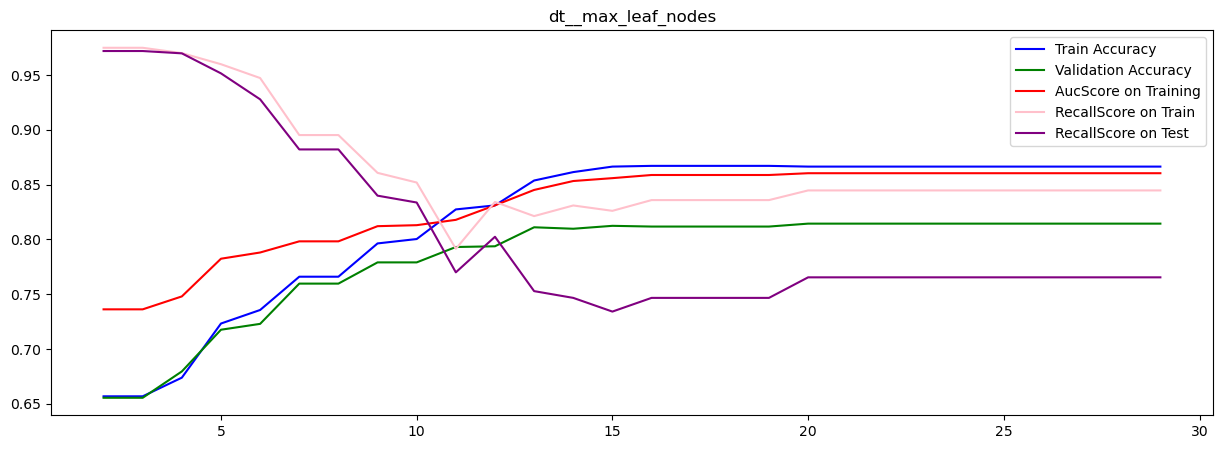

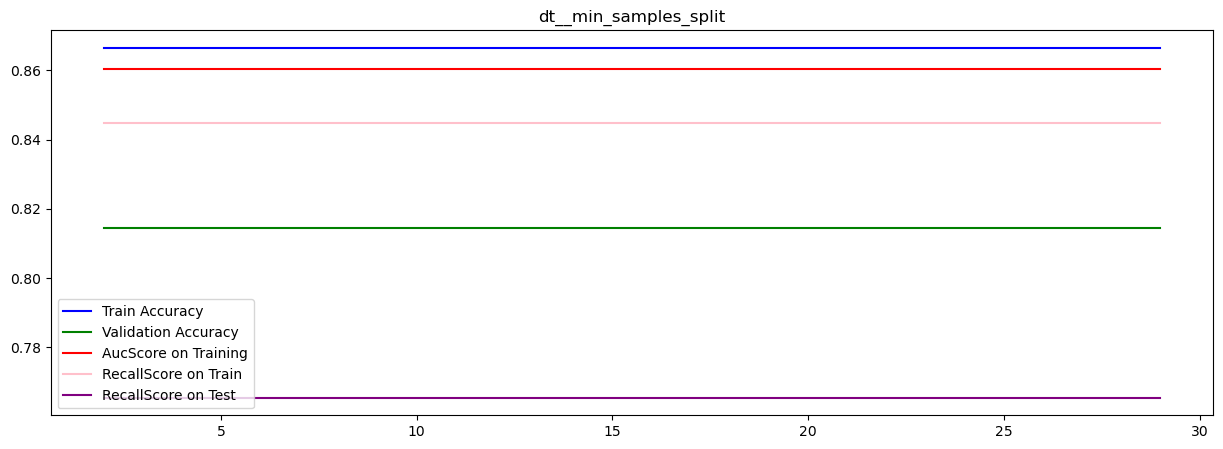

In [39]:
range_list = list(range(2, 30))

kf = KFold(n_splits=3)
parameter_names_list = ['dt__min_samples_leaf', 'dt__max_depth', 'dt__max_leaf_nodes', 'dt__min_samples_split']

for i in parameter_names_list:
    parameter_graph(range_list, try_params, i, X_temp, y_temp)

In [40]:
# rebuild a model on the combined training and validation set,
# and evaluate it on the test set

y_pred = pipe_tuned.predict(X_test)  
y_pred_temp = pipe_tuned.predict(X_temp) 

score_acc_temp = accuracy_score(y_temp, y_pred_temp)  
score_roc = roc_auc_score(y_test, y_pred)  
score_recall = recall_score(y_test, y_pred)  
score_recall_temp = recall_score(y_temp, y_pred_temp)  
score_acc = accuracy_score(y_test, y_pred)



print("Temp accuracy: {:.3f}".format(score_acc_temp))
print("Testing accuracy: {:.3f}".format(score_acc))

print("~"*25)

print("Recall score on temp: {:.3f}".format(score_recall_temp))
print("Recall score: {:.3f}".format(score_recall))
print("ROC-AUC score: {:.3f}".format(score_roc))

Temp accuracy: 0.874
Testing accuracy: 0.844
~~~~~~~~~~~~~~~~~~~~~~~~~
Recall score on temp: 0.844
Recall score: 0.772
ROC-AUC score: 0.826


# Interpreting Learning Curve
Learning curve is really useful to detect overfitting/underfitting. Basically, we want validation loss and training error to converge to irreducible error which is also graphed on the graph below. If, at some point training error decreases a lot, while validation error is increasing, it means the model is overfitting.

In [45]:
split_list = [float("{:.2f}".format(x)) for x in list(np.arange(0.01, 1, 0.02))]
learning_curve_loss(pipe_tuned, X, y, split_list, cross=skf)

# Let's visualize our tree!

In [47]:
fig, axes = plt.subplots(figsize = (10,10), dpi=900)
tree.plot_tree(pipe_tuned["dt"],
           feature_names = list(X.columns), 
           class_names=["not Star", "Star"],
           filled = True,
           label = False,
           impurity = False,
           ax = axes)
axes.set_title('Tree', fontsize = 13)
fig.savefig('decision_tree.png')

# Let's graph some more!

In [48]:
pipe_tuned.steps

[('imputer', KNNImputer(n_neighbors=7, weights='distance')),
 ('resample', SMOTE(random_state=42)),
 ('scaler', MinMaxScaler()),
 ('dt',
  DecisionTreeClassifier(max_depth=12, max_leaf_nodes=16, min_samples_leaf=16,
                         random_state=42))]

In [49]:
X = df.drop(['isStar'], axis=1)
y = df['isStar']

In [50]:
imputer = pipe_tuned["imputer"]
scale = pipe_tuned["scaler"] # we will not do the scaling so the 3d graphs turns out more interpretable!
sm = pipe["resample"]

X = imputer.transform(X)
X = pd.DataFrame(X)
X_res, y_res = sm.fit_resample(X, y)
X_res

0          1          2          3
0     24.980326  51.445268  52.620208  54.064555
1     46.313938  57.679403  58.389993  43.238722
2     32.699599  62.227628  58.032217  23.819467
3      8.144348  50.780760  45.763862  30.968590
4     45.845400  84.913413  53.670683  55.602772
...         ...        ...        ...        ...
2657  30.268081  53.342594  52.868697  23.402315
2658  21.791377  65.036182  37.946796  28.923667
2659  23.066750  56.350496  26.884911  24.521219
2660  25.129421  45.113216  45.300868  35.923897
2661  16.132755  63.812634  85.856015  30.444990

[2662 rows x 4 columns]

In [51]:
df_res = pd.concat([X_res, y_res], axis=1)
df_res

0          1          2          3  isStar
0     24.980326  51.445268  52.620208  54.064555   False
1     46.313938  57.679403  58.389993  43.238722   False
2     32.699599  62.227628  58.032217  23.819467   False
3      8.144348  50.780760  45.763862  30.968590   False
4     45.845400  84.913413  53.670683  55.602772    True
...         ...        ...        ...        ...     ...
2657  30.268081  53.342594  52.868697  23.402315    True
2658  21.791377  65.036182  37.946796  28.923667    True
2659  23.066750  56.350496  26.884911  24.521219    True
2660  25.129421  45.113216  45.300868  35.923897    True
2661  16.132755  63.812634  85.856015  30.444990    True

[2662 rows x 5 columns]

In [52]:
not_star_max_res = df_res["isStar"].value_counts()[0]
star_max_res = df_res["isStar"].value_counts()[1]

# That's how our data looks after resampling!

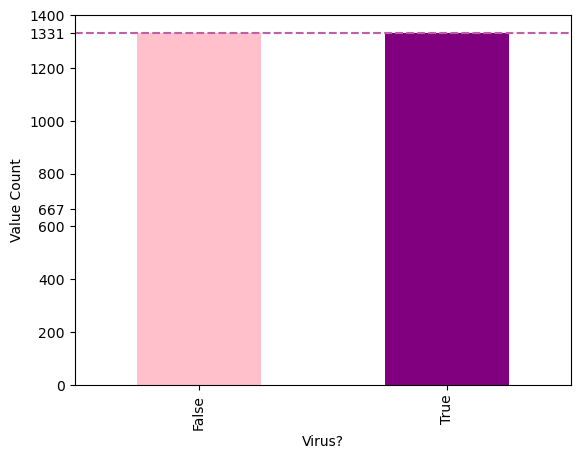

In [53]:
ax = df_res["isStar"].value_counts().plot.bar(xlabel='star?', ylabel='Value Count', color = ["pink", "purple"])
plt.axhline(y=not_star_max_res, color='pink', linestyle='--')
plt.axhline(y=star_max_res, color='purple', linestyle='--', alpha=0.5)

extra_ticks = [not_star_max_res, star_max_res]

ax.set_yticks(list(ax.get_yticks()) + extraticks)

plt.show()

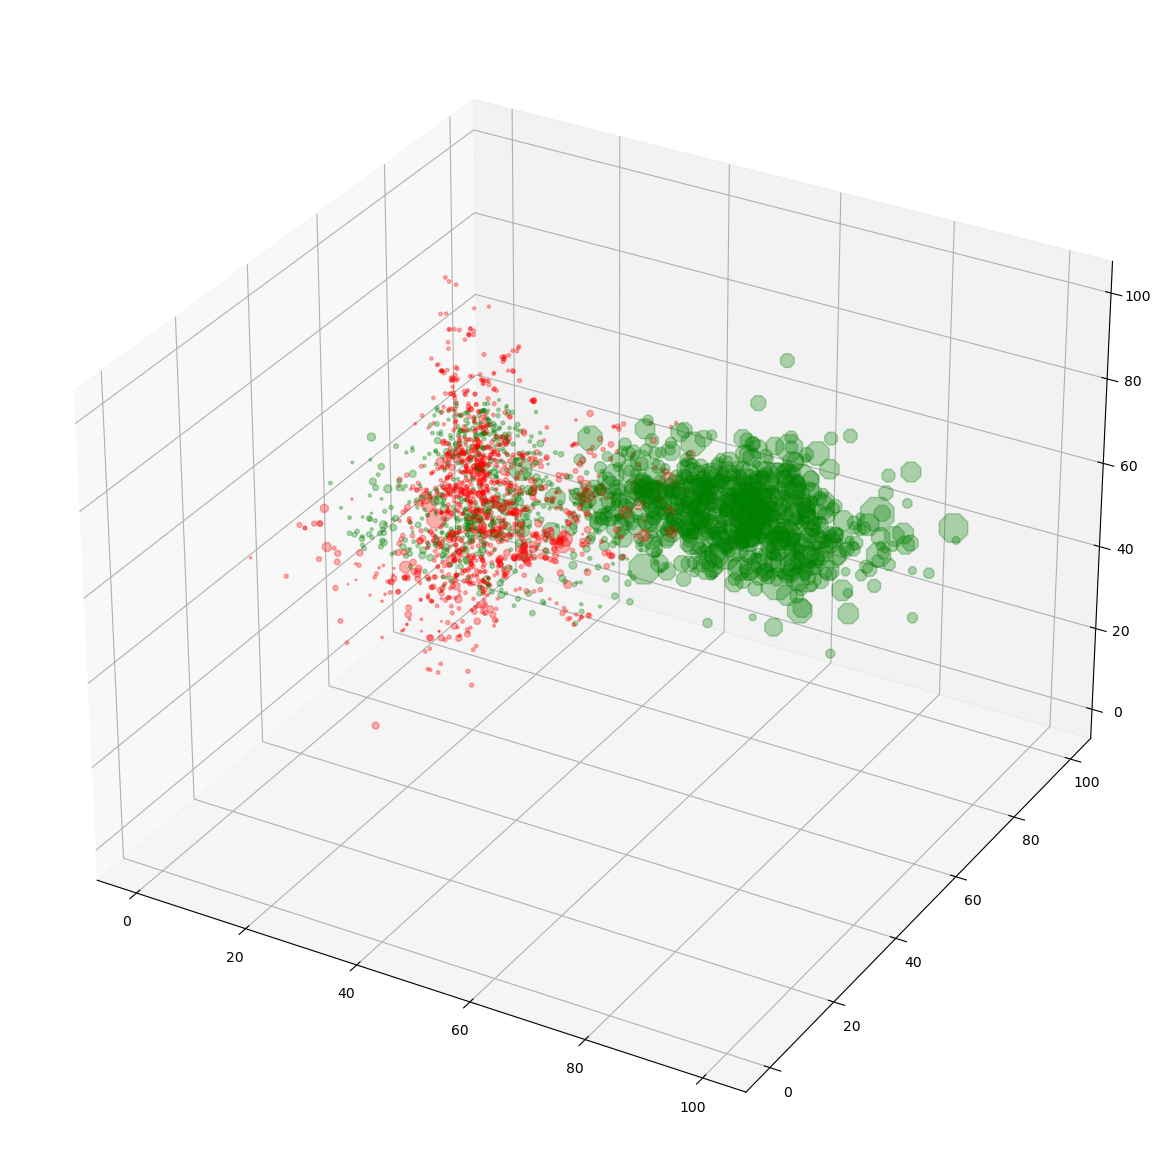

In [55]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')


colors = np.where(df_res["isStar"]==True,'red','green')

x, y, z = df_res[0], df_res[1], df_res[2]

s = [2**(row/10) for row in df_res[3]]

sctt = ax.scatter(x, y, z, s = s, 
                  alpha = 0.3, c = colors, marker ='8')

plt.show()

In [56]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Confusion Matrix

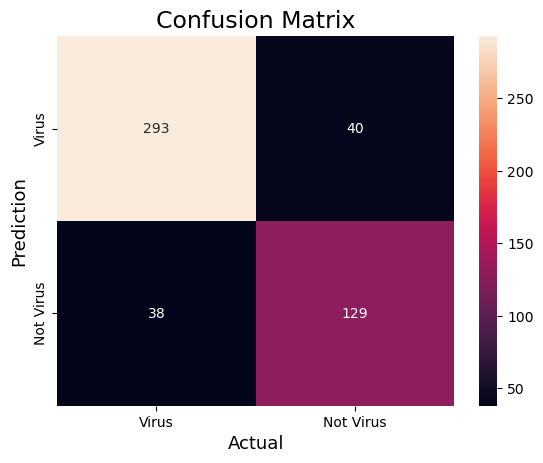

In [57]:
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['star','Not star'],
            yticklabels=['star','Not star'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [58]:
misclassified = np.where(y_pred != y_test)
print(misclassified)

(array([  1,   5,  29,  42,  50,  52,  53,  54,  58,  64,  69,  70,  72,
        79,  81,  93,  94, 101, 111, 112, 113, 124, 128, 131, 136, 137,
       144, 164, 171, 177, 183, 185, 187, 195, 202, 219, 227, 230, 241,
       243, 247, 254, 264, 276, 279, 307, 313, 316, 318, 321, 322, 326,
       334, 338, 347, 348, 350, 356, 365, 367, 368, 370, 372, 381, 384,
       418, 434, 437, 446, 447, 458, 475, 478, 481, 482, 485, 486, 493]),)


In [59]:
df_miss = df_res.loc[list(misclassified[0])]

In [60]:
df_miss

0          1          2          3  isStar
1    46.313938  57.679403  58.389993  43.238722   False
5    42.916780  85.345533  44.541668  45.005129    True
29   27.704860  62.091229  45.570589  13.795965   False
42   27.868326  66.553108  50.986550  44.928277    True
50   17.162349  67.793289  46.641239  41.302081   False
..         ...        ...        ...        ...     ...
481  13.199651  44.752584  46.825552  40.267161   False
482  25.467298  60.767956  48.635358  48.458462    True
485  22.093136  47.768735  51.486451  31.822903    True
486  56.804315  55.543908  53.875530  38.069029   False
493  31.810727  33.129692  47.586734  34.406319    True

[78 rows x 5 columns]

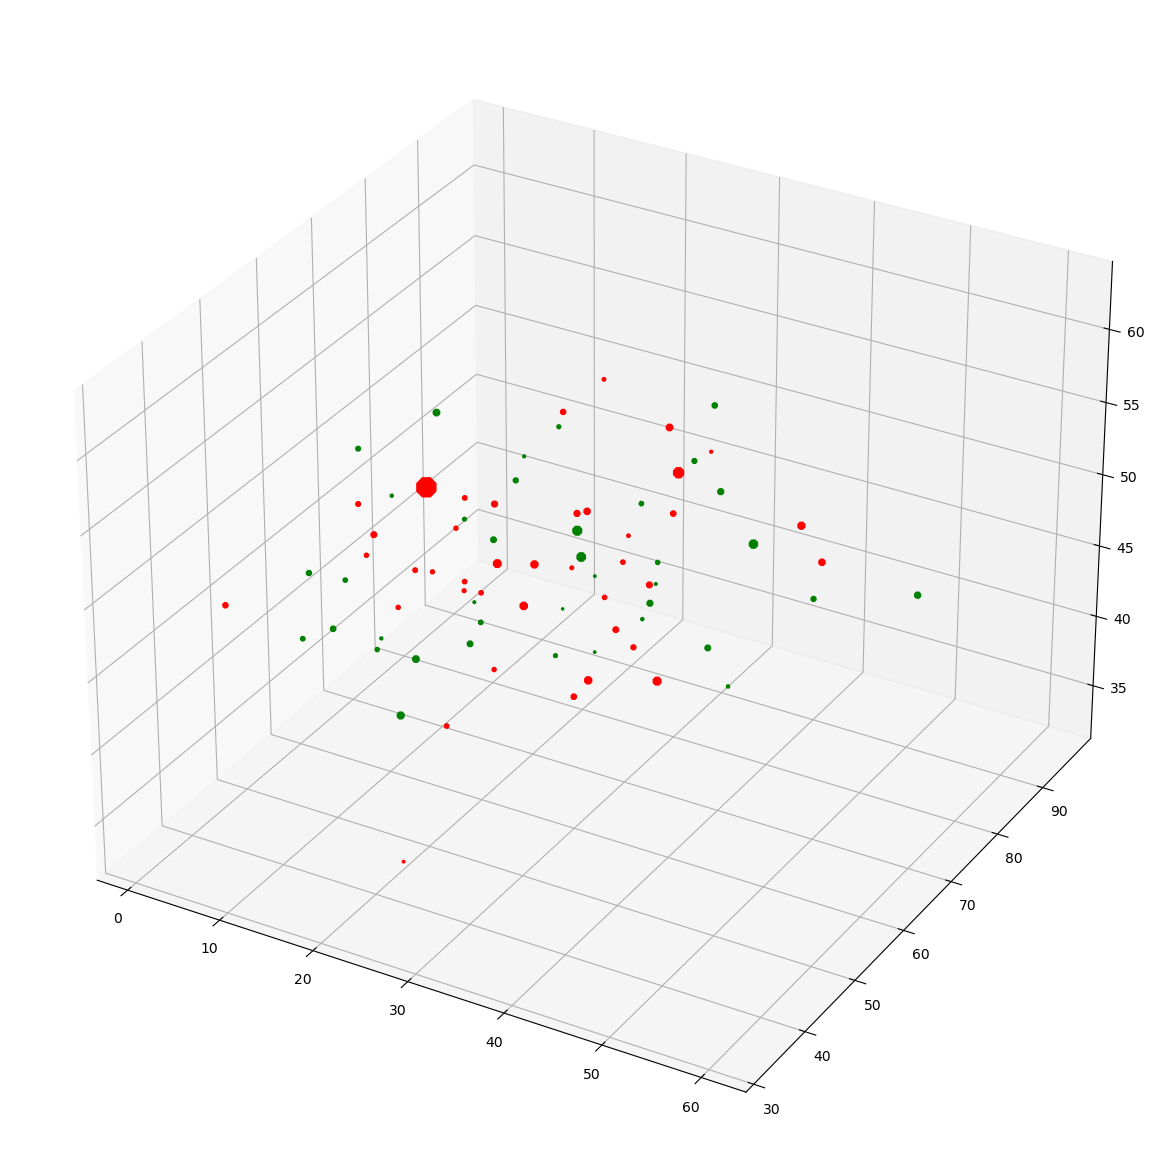

In [62]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')


x, y, z = df_miss[0], df_miss[1], df_miss[2]

s = [2**(row/10) for row in df_miss[3]]

colors_miss = np.where(df_miss["isStar"]==True,'red','green')


sctt = ax.scatter(x, y, z, s = s, 
                  alpha = 1, marker ='8', c = colors_miss)

plt.show()

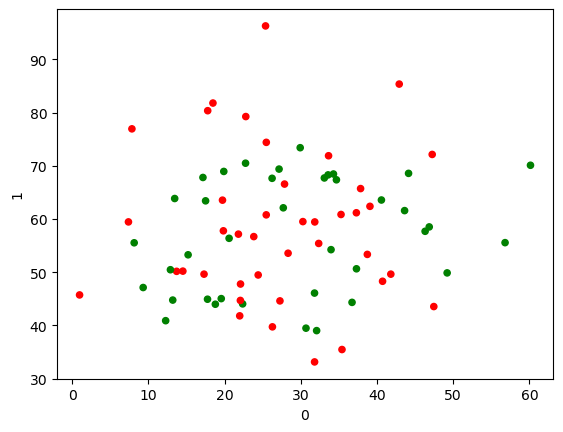

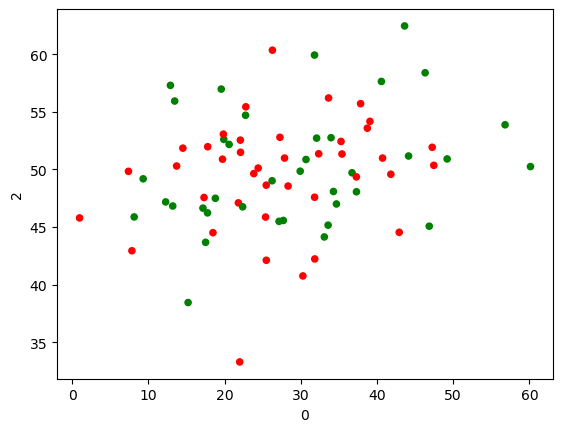

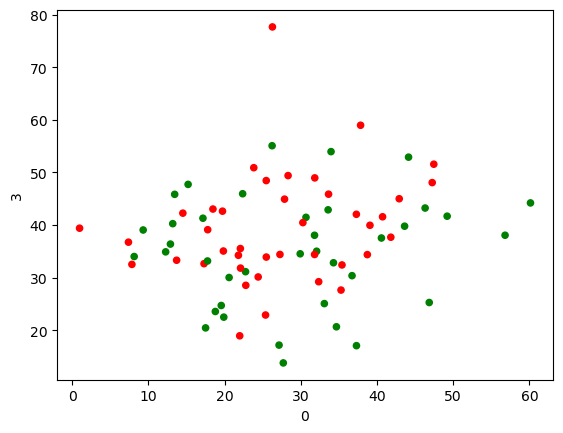

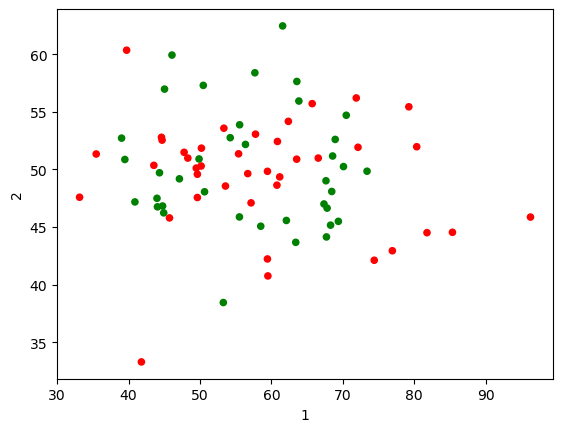

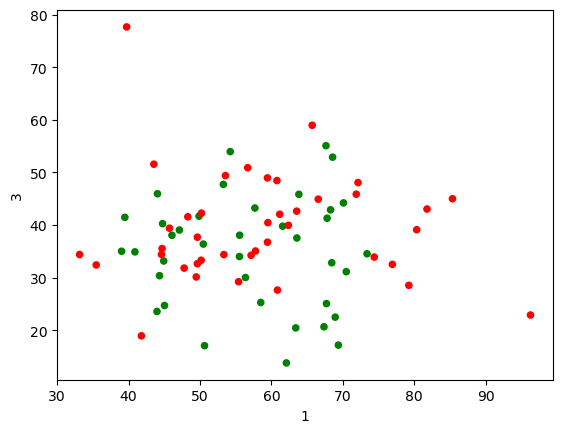

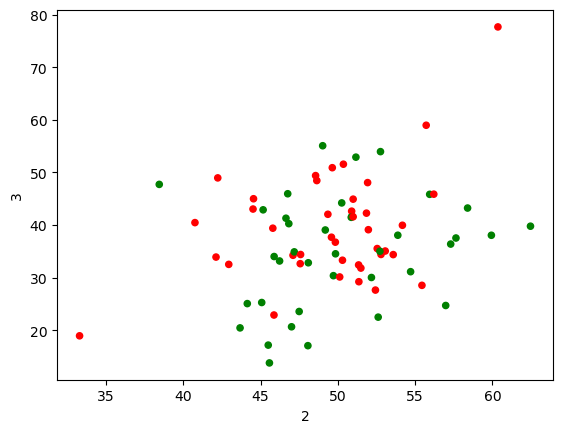

In [63]:
colors_miss = np.where(df_miss["isStar"]==True,'red','green')
for x, y in combinations(df_miss.drop(columns="isStar").columns, r=2):
    ax = df_miss.plot.scatter(x=x, y=y, c=colors_miss)

In [64]:
miss_index = (df_miss["isStar"]==True).index

# Scatter plot the values which were classified wrongly, next to their neighbors. 

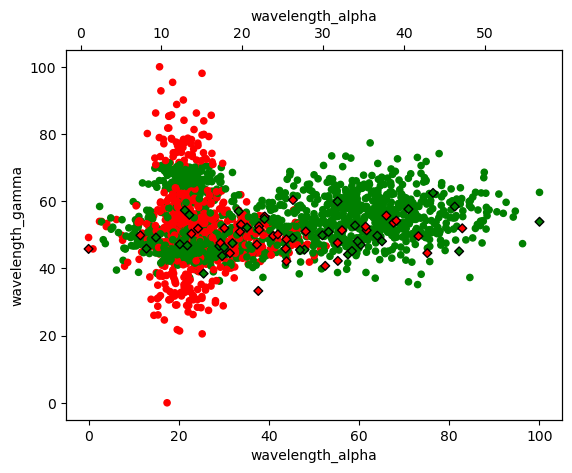

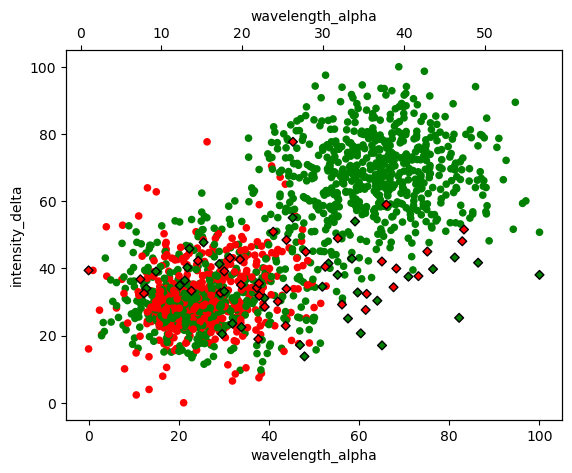

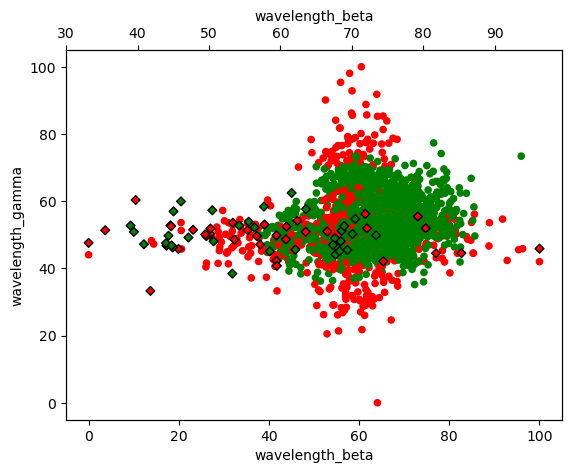

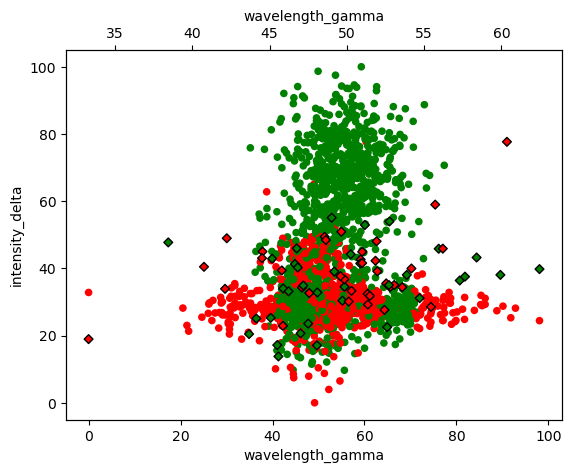

<Figure size 640x480 with 0 Axes>

In [65]:
colors_miss = np.where(df_miss["isStar"] == True,'red','green')
colors = np.where(df["isStar"] == True,'red','green')

for x, y in combinations(df.drop(columns="isStar").columns, r=2):
    ax = fig.add_subplot(111)
    ax2 = ax.twiny()

    df.plot.scatter(x=x,y=y, ax=ax, c=colors)

    df.loc[miss_index].plot.scatter(x=x,y=y, ax=ax2, c=colors_miss, edgecolors = "black", marker="D")
    fig = plt.figure()
